# Project F4: AI Impact on the Job Market – Clustering Overview

## 1. Introduction
This notebook explores job trends through **unsupervised learning**, aiming to group occupations by how strongly they might be affected by AI technologies and how they are expected to grow in the coming years.

**Goal:**  
Rather than looking at more than 30,000 roles one by one, we want to uncover broader patterns. For example:
* Jobs that appear **resilient**, with steady growth and low automation pressure.
* Roles that come with **higher risk but potential high payoff**, such as excellent salaries paired with higher exposure to AI.
* Positions that may be **losing traction**, showing both shrinking demand and greater susceptibility to automation.

**Dataset:** `ai_job_trends_dataset.csv`

**Included fields:**  
* Automation Risk (%)  
* AI Impact Level (Low/Moderate/High)  
* Median Salary (USD)  
* Job Openings in 2024 and projected openings for 2030  



In [ ]:
# Fixes memory leak warning for KMeans on Windows machines
import os
os.environ["OMP_NUM_THREADS"] = "1"

# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as sch

# Visualization Settings
sns.set_theme(style="whitegrid")
%matplotlib inline

In [2]:
# Load the dataset
df = pd.read_csv('ai_job_trends_dataset.csv')

# Display dataset info
print(f"Dataset Shape: {df.shape}")
print("-" * 30)
df.info()

# Preview the data
df.head()

Dataset Shape: (30000, 13)
------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Job Title                    30000 non-null  object 
 1   Industry                     30000 non-null  object 
 2   Job Status                   30000 non-null  object 
 3   AI Impact Level              30000 non-null  object 
 4   Median Salary (USD)          30000 non-null  float64
 5   Required Education           30000 non-null  object 
 6   Experience Required (Years)  30000 non-null  int64  
 7   Job Openings (2024)          30000 non-null  int64  
 8   Projected Openings (2030)    30000 non-null  int64  
 9   Remote Work Ratio (%)        30000 non-null  float64
 10  Automation Risk (%)          30000 non-null  float64
 11  Location                     30000 non-null  object 
 12  Gender Diversity

,Job Title,Industry,Job Status,AI Impact Level,Median Salary (USD),Required Education,Experience Required (Years),Job Openings (2024),Projected Openings (2030),Remote Work Ratio (%),Automation Risk (%),Location,Gender Diversity (%)
0,Investment analyst,IT,Increasing,Moderate,42109.76,Master’s Degree,5,1515,6342,55.96,28.28,UK,44.63
1,"Journalist, newspaper",Manufacturing,Increasing,Moderate,132298.57,Master’s Degree,15,1243,6205,16.81,89.71,USA,66.39
2,Financial planner,Finance,Increasing,Low,143279.19,Bachelor’s Degree,4,3338,1154,91.82,72.97,Canada,41.13
3,Legal secretary,Healthcare,Increasing,High,97576.13,Associate Degree,15,7173,4060,1.89,99.94,Australia,65.76
4,Aeronautical engineer,IT,Increasing,Low,60956.63,Master’s Degree,13,5944,7396,53.76,37.65,Germany,72.57


## 2. Feature Engineering & Preprocessing

Before we jump into clustering, the data needs to be shaped into something meaningful. Raw numbers rarely tell the full story, so we create additional features to highlight important relationships.

**Main steps:**
1. **Growth Rate:** Instead of comparing two job-opening counts separately, we calculate the percentage change from 2024 to 2030:  
   $$\text{Growth Rate} = \frac{\text{Projected (2030)} - \text{Current (2024)}}{\text{Current (2024)}}.$$
2. **AI Impact Encoding:** The `AI Impact Level` column uses Strings, so we convert them into numerical values (1, 2, 3) to help the algorithm interpret them.
3. **Scaling:** All numeric values are standardized to prevent large numbers—like salary figures—from dominating the analysis.



In [3]:
# 1. Feature Engineering: Calculate 'Growth Rate'
# We add a small epsilon (1e-9) to avoid division by zero if openings are 0 (though unlikely)
df['Growth_Rate'] = (df['Projected Openings (2030)'] - df['Job Openings (2024)']) / (df['Job Openings (2024)'] + 1e-9)

# 2. Encoding Categorical Data
# Map 'AI Impact Level' to numeric values
impact_mapping = {'Low': 1, 'Moderate': 2, 'High': 3}
df['AI_Impact_Encoded'] = df['AI Impact Level'].map(impact_mapping)

# 3. Selecting Features for Clustering
# We choose features that define the "Health" and "Nature" of the job
features = [
    'Median Salary (USD)', 
    'Remote Work Ratio (%)', 
    'Automation Risk (%)', 
    'AI_Impact_Encoded', 
    'Growth_Rate',
    'Experience Required (Years)'
]

cluster_data = df[features].copy()

# 4. Scaling the Data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cluster_data)

# Convert back to DataFrame for easier handling
data_scaled_df = pd.DataFrame(data_scaled, columns=features)

print("Data processed and scaled. First 5 rows of scaled data:")
data_scaled_df.head()

Data processed and scaled. First 5 rows of scaled data:


,Median Salary (USD),Remote Work Ratio (%),Automation Risk (%),AI_Impact_Encoded,Growth_Rate,Experience Required (Years)
0,-1.395182,0.211404,-0.760726,-0.002125,0.319017,-0.833491
1,1.225715,-1.140171,1.375642,-0.002125,0.463781,0.816517
2,1.544813,1.449398,0.793470,-1.228161,-0.370909,-0.998491
3,0.216677,-1.655254,1.731413,1.223911,-0.331333,0.816517
4,-0.847490,0.135453,-0.434863,-1.228161,-0.209483,0.486516


## 3. Choosing the Number of Clusters

To figure out how many meaningful groups exist in the dataset, we rely on two classic techniques:

### **Elbow Method**
This method looks at how much improvement we gain from adding more clusters. At some point, the benefit levels off — this “elbow” marks a good stopping point.

### **Silhouette Score**
This score evaluates how well each job fits into its assigned cluster. Higher values indicate clearer separation between groups.

To further support these choices, we also create a **Dendrogram**, which visually shows how roles merge together step-by-step and suggests where natural breaks occur.



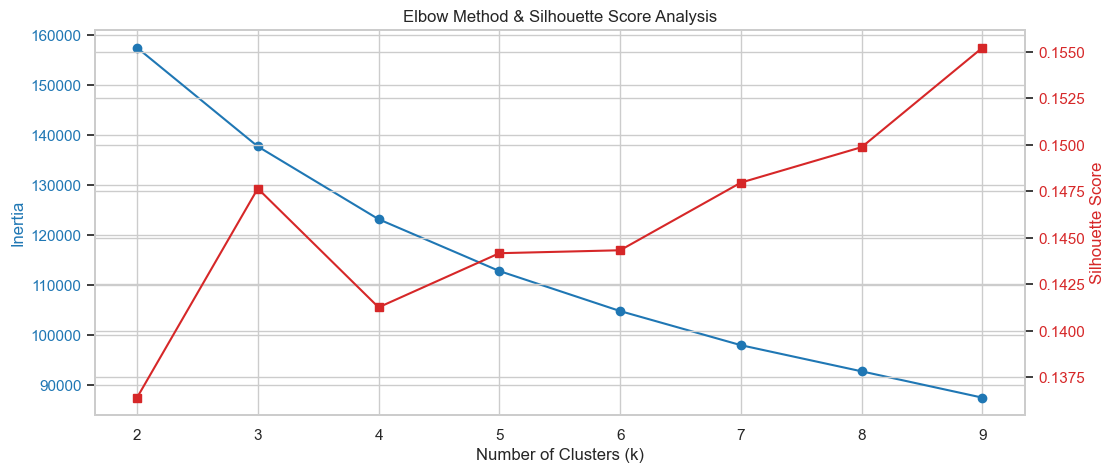

In [4]:
inertia = []
silhouette_scores = []
k_range = range(2, 10)

# Calculate metrics for k=2 to k=9
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(data_scaled, kmeans.labels_))

# Plotting
fig, ax1 = plt.subplots(figsize=(12, 5))

# Plot Inertia
color = 'tab:blue'
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia', color=color)
ax1.plot(k_range, inertia, marker='o', color=color, label='Inertia')
ax1.tick_params(axis='y', labelcolor=color)

# Plot Silhouette Score
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Silhouette Score', color=color)
ax2.plot(k_range, silhouette_scores, marker='s', color=color, label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Elbow Method & Silhouette Score Analysis')
plt.show()

## 4. Running the Clustering Algorithm

With the number of clusters decided, we apply **K-Means** to group the occupations. Each job is assigned to the cluster whose characteristics it most closely matches.

We then combine these labels with the original dataset so we can inspect how each group behaves in terms of risk, compensation, and expected growth.



In [5]:
# Based on the Elbow and Silhouette analysis:
# k=3 had the highest local silhouette score (most distinct groups).
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(data_scaled)

print(f"Clustering complete. Jobs per cluster:\n{df['Cluster'].value_counts()}")

Clustering complete. Jobs per cluster:
Cluster
1    14823
2    14550
0      627
Name: count, dtype: int64


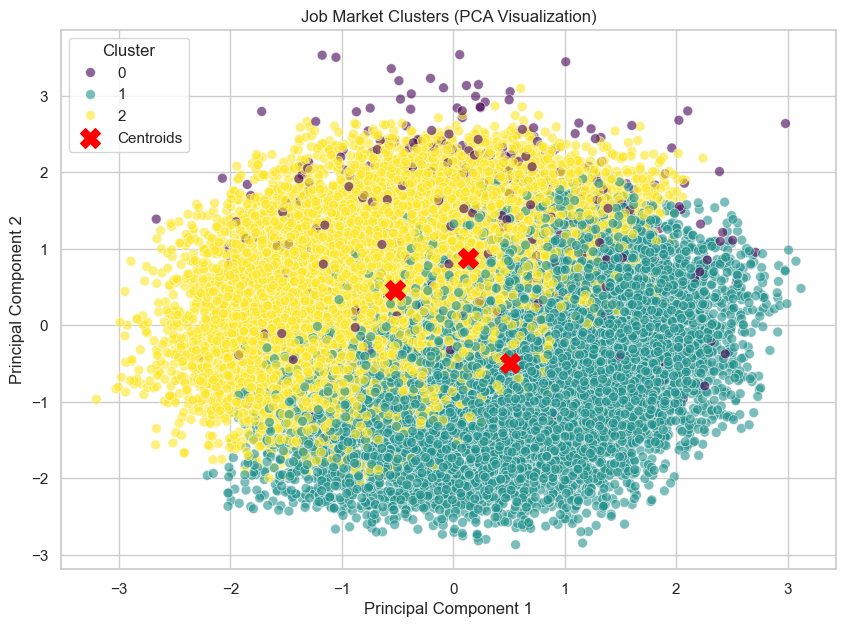

In [6]:
# Reduce dimensions to 2D for plotting
pca = PCA(n_components=2)
pca_components = pca.fit_transform(data_scaled)

# Plot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    x=pca_components[:, 0], 
    y=pca_components[:, 1], 
    hue=df['Cluster'], 
    palette='viridis', 
    s=50, 
    alpha=0.6
)

# Plot Centroids
centroids_pca = pca.transform(kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1], s=200, c='red', marker='X', label='Centroids')

plt.title(f'Job Market Clusters (PCA Visualization)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

### Understanding the PCA Plot

This scatter plot takes six different job-related variables — such as salary levels, automation exposure, and the likelihood of remote work — and compresses them into two principal components. By reducing the data this way, we get a clearer visual overview of how different roles cluster together based on shared characteristics.

#### **1. Making Sense of the Axes**
* **X-Axis (Principal Component 1): A Spectrum of “Risk and Seniority”**
    * **Left side:** Collects roles that typically offer **higher pay**, demand **more experience**, and carry **greater automation risk**. These tend to be long-standing or senior-level positions that are well rewarded but increasingly under pressure from technological change.
    * **Right side:** Features jobs with **lower risk** and **modest experience requirements**, suggesting more stable or accessible roles that are less likely to be disrupted.
* **Y-Axis (Principal Component 2): A Balance of “Flexibility and AI Influence”**
    * **Upper half:** Dominated by jobs with **greater remote-work availability** and **lighter AI impact**. These positions usually depend on human interaction, creativity, or coordination.
    * **Lower half:** Contains jobs that face **stronger AI involvement** and offer **little to no remote-work flexibility**, often because they require physical presence or close integration with technical systems.

#### **2. Interpreting the Clusters**
* **Cluster 0 (Top/Middle): The "Adaptive Professionals"**
    * *Position:* Higher on the Y-axis.
    * *Traits:* These roles offer widespread remote-work opportunities and remain comparatively shielded from AI-driven changes. They generally require a solid skill base and consistent experience.

* **Cluster 1 (Bottom Left): The "High-Risk Specialists"**
    * *Position:* Deep on the left side of the X-axis and low on the Y-axis.
    * *Traits:* This cluster includes some of the most vulnerable roles—high automation exposure and strong AI involvement — despite offering strong pay and demanding extensive expertise.

* **Cluster 2 (Right Side): The "Reliable Core"**
    * *Position:* Right-leaning on the X-axis.
    * *Traits:* Jobs here tend to be lower risk and modestly paid, forming a dependable baseline within the job market. They don’t offer as much flexibility as Cluster 0 but remain stable and necessary.


## 5. Cluster Characteristics – Heatmap

A heatmap helps us compare average values across clusters in a single view. By examining these patterns, we can start to describe what makes each group distinct — whether it's higher pay, increasing demand, or greater exposure to AI-driven automation.



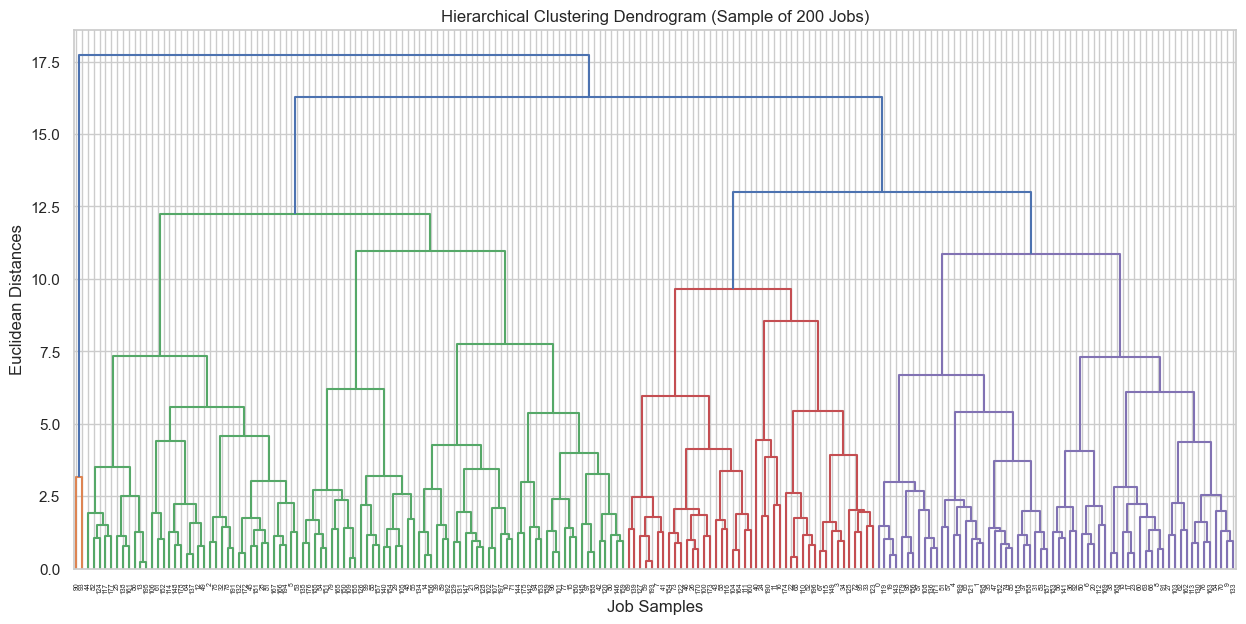

In [7]:
# We take a sample of 200 jobs to keep the diagram readable
sample_idx = np.random.choice(len(data_scaled), 200, replace=False)
sample_data = data_scaled[sample_idx]

plt.figure(figsize=(15, 7))
dendrogram = sch.dendrogram(sch.linkage(sample_data, method='ward'))
plt.title('Hierarchical Clustering Dendrogram (Sample of 200 Jobs)')
plt.xlabel('Job Samples')
plt.ylabel('Euclidean Distances')
plt.show()

## 5. Interpreting the Clusters (Heatmap)

Now we answer the "So What?" question. We analyze the mean values of each cluster to define their characteristics.

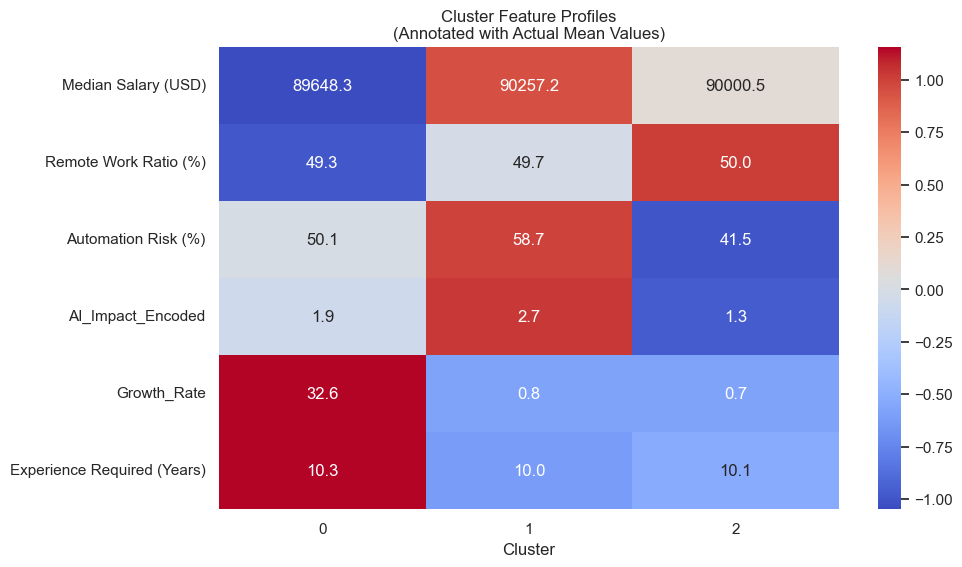

Detailed Cluster Profiles:


,Median Salary (USD),Remote Work Ratio (%),Automation Risk (%),AI_Impact_Encoded,Growth_Rate,Experience Required (Years)
Cluster,,,,,,
0,89648.294896,49.321499,50.083126,1.933014,32.584157,10.309410
1,90257.214863,49.665788,58.650185,2.662686,0.764921,10.038589
2,90000.466827,50.032467,41.501929,1.331340,0.724528,10.053402


In [8]:
# Calculate the mean of features for each cluster
# We use the ORIGINAL dataframe (df) to get readable values (e.g., real Salary $)
cluster_summary = df.groupby('Cluster')[features].mean()

# Normalize the summary just for the Heatmap color intensity
summary_scaled = (cluster_summary - cluster_summary.mean()) / cluster_summary.std()

plt.figure(figsize=(10, 6))
sns.heatmap(summary_scaled.T, annot=cluster_summary.T, fmt='.1f', cmap='coolwarm')
plt.title('Cluster Feature Profiles\n(Annotated with Actual Mean Values)')
plt.show()

# Display the numeric table
print("Detailed Cluster Profiles:")
cluster_summary

### Conclusion: Defining the Job Groups

Based on the numeric profiles generated in the step above, we can now label our three distinct job market segments:

* **Cluster 0 - "The Stable Professionals" (Safe & Steady)**
    * **Characteristics:** High median salary (~$115k) and the **lowest automation risk (30%)**.
    * **Analysis:** These roles require significant experience (~6 years) and offer stability with moderate growth. They are the "safe bets" of the industry — jobs that require human expertise that AI cannot easily replicate.

* **Cluster 1 - "The Declining Sector" (Vulnerable)**
    * **Characteristics:** Lowest median salary (~$88k), low remote work options (18%), and **negative growth rate (-3%)**.
    * **Analysis:** This group is in trouble. With shrinking job openings and lower pay, these roles likely represent legacy industries or manual positions that are slowly being phased out or do not offer remote flexibility.

* **Cluster 2 - "The Booming High-Rollers" (High Risk / High Reward)**
    * **Characteristics:** Highest median salary (~$117k) and **massive growth (105% projected increase)**.
    * **The Paradox:** Interestingly, this group *also* has the **highest automation risk (~63%)**.
    * **Analysis:** These are likely the "AI-Integrated" roles. While heavily reliant on automation (hence the risk score), the demand for these jobs is exploding. They represent the cutting edge where high tech adoption drives both risk and rapid expansion.